# Autoencoder

Some piece of codes taken from https://github.com/kevinzakka/vae-pytorch

In [4]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

# plotting params
%matplotlib inline
#plt.rcParams['font.size'] = 10
#plt.rcParams['axes.labelsize'] = 10
#plt.rcParams['axes.titlesize'] = 10
#plt.rcParams['xtick.labelsize'] = 8
#plt.rcParams['ytick.labelsize'] = 8
#plt.rcParams['legend.fontsize'] = 10
#plt.rcParams['figure.titlesize'] = 12
#plt.rcParams['figure.figsize'] = (8.0, 8.0)

In [5]:
torch.manual_seed(423212)

## Loading MNIST

In [6]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       # transforms.Normalize((0.1307,), (0.3081,))
                       # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                   ])),
    batch_size=128, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       # transforms.Normalize((0.1307,), (0.3081,))
                       # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                   ])),
                    batch_size=10, shuffle=False)

## Helper Functions

In [12]:
def to_img(x):
    x = x.data.numpy()
    x = 0.5 * (x + 1)
    x = np.clip(x, 0, 1)
    x = x.reshape([-1, 28, 28])
    return x

def plot_reconstructions(model, conv=False, simple=False):
    """
    Plot 10 reconstructions from the test set. The top row is the original
    digits, the bottom is the decoder reconstruction.
    The middle row is the encoded vector.
    """
    # encode then decode
    data, _ = next(iter(test_loader))
    if not conv:
        data = data.view([-1, 784])
    data = Variable(data, volatile=True)
    true_imgs = data
    encoded_imgs = model.encoder(data)
    if simple:
        encoded_imgs = F.relu(encoded_imgs)
    decoded_imgs = model.decoder(encoded_imgs)
    
    true_imgs = to_img(true_imgs)
    decoded_imgs = to_img(decoded_imgs)
    encoded_imgs = encoded_imgs.data.numpy()
    
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(true_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(encoded_imgs[i].reshape(-1,4))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(3, n, i + 1 + n + n)
        plt.imshow(decoded_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.show()

## Simple Auto-Encoder

We'll start with the simplest autoencoder: a single, fully-connected layer as the encoder and decoder.

In [8]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Linear(input_dim, encoding_dim)
        self.decoder = nn.Linear(encoding_dim, input_dim)

    def forward(self, x):
        encoded = F.relu(self.encoder(x))
        decoded = self.decoder(encoded)
        return decoded, encoded

In [9]:
input_dim = 784
encoding_dim = 32

model = AutoEncoder(input_dim, encoding_dim)
optimizer = optim.Adam(model.parameters())

In [10]:
def train(epoch, sparsity=False):
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data.view([-1, 784]))
        optimizer.zero_grad()
        
        output, _ = model(data)
        loss = F.mse_loss(output, data)
        #loss = F.binary_cross_entropy_with_logits(output, data)
            
        loss.backward()
        optimizer.step()
        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

In [11]:
num_epochs = 30

for epoch in range(1,  num_epochs + 1):
    train(epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.127600
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.072044
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.062862
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.054722
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.050736
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.046105
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.045780
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.043668
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.040404
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.041125
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.039240
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.035589
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.034980
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.033013
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.030515
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.030512
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.030410
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.029715
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.031097
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.028892
Train Epoch:

Train Epoch: 17 [32000/60000 (53%)]	Loss: 0.029090
Train Epoch: 17 [38400/60000 (64%)]	Loss: 0.028432
Train Epoch: 17 [44800/60000 (75%)]	Loss: 0.029547
Train Epoch: 17 [51200/60000 (85%)]	Loss: 0.027841
Train Epoch: 17 [57600/60000 (96%)]	Loss: 0.029180
Train Epoch: 18 [0/60000 (0%)]	Loss: 0.028696
Train Epoch: 18 [6400/60000 (11%)]	Loss: 0.028982
Train Epoch: 18 [12800/60000 (21%)]	Loss: 0.027159
Train Epoch: 18 [19200/60000 (32%)]	Loss: 0.027466
Train Epoch: 18 [25600/60000 (43%)]	Loss: 0.028732
Train Epoch: 18 [32000/60000 (53%)]	Loss: 0.029160
Train Epoch: 18 [38400/60000 (64%)]	Loss: 0.029305
Train Epoch: 18 [44800/60000 (75%)]	Loss: 0.029006
Train Epoch: 18 [51200/60000 (85%)]	Loss: 0.026996
Train Epoch: 18 [57600/60000 (96%)]	Loss: 0.028732
Train Epoch: 19 [0/60000 (0%)]	Loss: 0.029378
Train Epoch: 19 [6400/60000 (11%)]	Loss: 0.026651
Train Epoch: 19 [12800/60000 (21%)]	Loss: 0.028458
Train Epoch: 19 [19200/60000 (32%)]	Loss: 0.028415
Train Epoch: 19 [25600/60000 (43%)]	Loss: 0

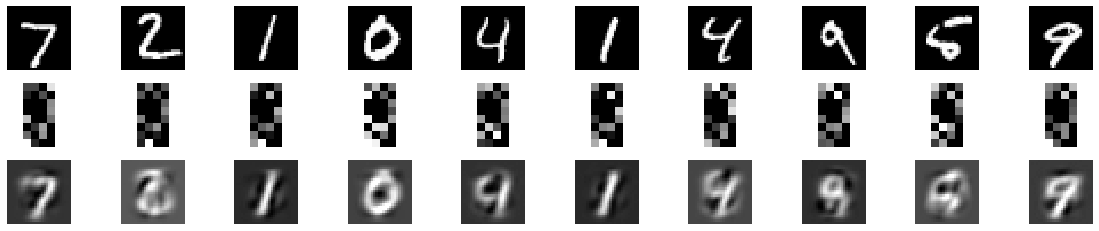

In [13]:
plot_reconstructions(model, simple=True)

## Stacked Auto-Encoder

In [14]:
class DeepAutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(DeepAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True), 
            nn.Linear(64, encoding_dim), 
            nn.ReLU(True),
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True), 
            nn.Linear(128, input_dim),
            # nn.Tanh()
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [15]:
input_dim = 784
encoding_dim = 32

model = DeepAutoEncoder(input_dim, encoding_dim)
optimizer = optim.Adam(model.parameters())

In [16]:
def train(epoch):
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data.view([-1, 784]))
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, data)
        #loss = F.binary_cross_entropy_with_logits(output, data)
        loss.backward()
        optimizer.step()
        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

In [17]:
num_epochs = 30

for epoch in range(1,  num_epochs + 1):
    train(epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.116248
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.062565
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.052740
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.044456
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.036830
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.033187
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.032983
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.032776
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.030563
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.028974
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.027866
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.025393
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.025532
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.025645
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.024938
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.024486
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.022996
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.022566
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.024554
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.022577
Train Epoch:

Train Epoch: 17 [32000/60000 (53%)]	Loss: 0.014835
Train Epoch: 17 [38400/60000 (64%)]	Loss: 0.016123
Train Epoch: 17 [44800/60000 (75%)]	Loss: 0.015595
Train Epoch: 17 [51200/60000 (85%)]	Loss: 0.015376
Train Epoch: 17 [57600/60000 (96%)]	Loss: 0.015132
Train Epoch: 18 [0/60000 (0%)]	Loss: 0.015529
Train Epoch: 18 [6400/60000 (11%)]	Loss: 0.015331
Train Epoch: 18 [12800/60000 (21%)]	Loss: 0.015817
Train Epoch: 18 [19200/60000 (32%)]	Loss: 0.015098
Train Epoch: 18 [25600/60000 (43%)]	Loss: 0.014851
Train Epoch: 18 [32000/60000 (53%)]	Loss: 0.014880
Train Epoch: 18 [38400/60000 (64%)]	Loss: 0.015550
Train Epoch: 18 [44800/60000 (75%)]	Loss: 0.014900
Train Epoch: 18 [51200/60000 (85%)]	Loss: 0.015145
Train Epoch: 18 [57600/60000 (96%)]	Loss: 0.015037
Train Epoch: 19 [0/60000 (0%)]	Loss: 0.015131
Train Epoch: 19 [6400/60000 (11%)]	Loss: 0.015501
Train Epoch: 19 [12800/60000 (21%)]	Loss: 0.015072
Train Epoch: 19 [19200/60000 (32%)]	Loss: 0.015182
Train Epoch: 19 [25600/60000 (43%)]	Loss: 0

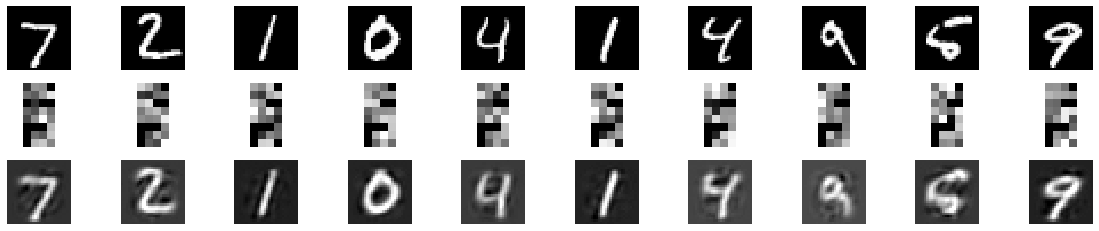

In [18]:
plot_reconstructions(model, conv=False, simple=False)

# Exercise

- Change the loss to a BCE loss. 

- Implement weight sharing.

Hint, a rapid google search gives:

https://discuss.pytorch.org/t/how-to-create-and-train-a-tied-autoencoder/2585

https://www.reddit.com/r/MachineLearning/comments/662rzo/p_using_tied_weights_in_pytorch/

## Convolutional Auto-Encoder

In [19]:
class ConvolutionalAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvolutionalAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [20]:
model = ConvolutionalAutoEncoder()
optimizer = optim.Adam(model.parameters())

In [21]:
def train(epoch):
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, data)
        #loss = F.binary_cross_entropy_with_logits(output, data)
        loss.backward()
        optimizer.step()
        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

In [22]:
num_epochs = 30

for epoch in range(1,  num_epochs + 1):
    train(epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.104656
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.089290
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.068994
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.061214
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.056738
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.056462
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.051464
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.050489
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.046483
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.044178
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.046872
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.042071
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.043188
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.041239
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.040027
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.042477
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.039615
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.040321
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.040079
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.039466
Train Epoch:

Train Epoch: 17 [32000/60000 (53%)]	Loss: 0.028434
Train Epoch: 17 [38400/60000 (64%)]	Loss: 0.026169
Train Epoch: 17 [44800/60000 (75%)]	Loss: 0.026915
Train Epoch: 17 [51200/60000 (85%)]	Loss: 0.026216
Train Epoch: 17 [57600/60000 (96%)]	Loss: 0.027675
Train Epoch: 18 [0/60000 (0%)]	Loss: 0.028720
Train Epoch: 18 [6400/60000 (11%)]	Loss: 0.026995
Train Epoch: 18 [12800/60000 (21%)]	Loss: 0.026252
Train Epoch: 18 [19200/60000 (32%)]	Loss: 0.027700
Train Epoch: 18 [25600/60000 (43%)]	Loss: 0.025921
Train Epoch: 18 [32000/60000 (53%)]	Loss: 0.025902
Train Epoch: 18 [38400/60000 (64%)]	Loss: 0.028542
Train Epoch: 18 [44800/60000 (75%)]	Loss: 0.026521
Train Epoch: 18 [51200/60000 (85%)]	Loss: 0.026909
Train Epoch: 18 [57600/60000 (96%)]	Loss: 0.025501
Train Epoch: 19 [0/60000 (0%)]	Loss: 0.029589
Train Epoch: 19 [6400/60000 (11%)]	Loss: 0.029193
Train Epoch: 19 [12800/60000 (21%)]	Loss: 0.026916
Train Epoch: 19 [19200/60000 (32%)]	Loss: 0.028137
Train Epoch: 19 [25600/60000 (43%)]	Loss: 0

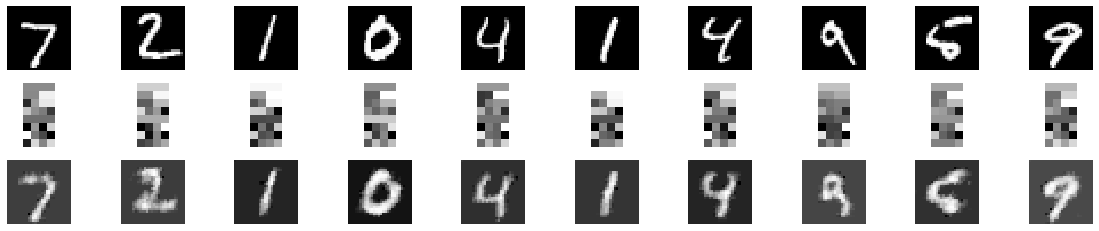

In [23]:
plot_reconstructions(model, conv=True, simple=False)

# Exercise

Implement a denoising AE:

![denoising AE](denoisingAE.png)